In [16]:
# If you are not working on Google Colab, please set the variable to False.

colab = True

if colab:
  from google.colab import drive
  drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [17]:
if colab:
  import subprocess
  from google.colab import files

  bashCommand = "pip install torch-summary dival"
  process = subprocess.Popen(bashCommand.split(), stdout=subprocess.PIPE)
  output, error = process.communicate()

import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms as transforms

from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from dival.measure import PSNR, SSIM
from torchsummary import summary

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on GPU", torch.cuda.get_device_name(device))
else:
    device = torch.device("cpu")
    print("Running on CPU")

Running on GPU Tesla T4


In [4]:
# Dataset

class LIDCDataset(Dataset):

  def __init__(self, root_dir_fbp, root_dir_gr, transform = None) :

    self.root_dir_fbp = root_dir_fbp
    self.root_dir_gr = root_dir_gr
    self.file_list = self.create_dataset()
    self.transform = transform

  def __len__(self):
    return len(self.file_list)

  def __getitem__(self, index):

    fbp_path = os.path.join(self.root_dir_fbp, self.file_list[index])
    gr_path = os.path.join(self.root_dir_gr, self.file_list[index])

    fbp_im = np.load(fbp_path)
    fbp_im = np.expand_dims(fbp_im, axis=0)
    fbp_tensor = torch.Tensor(fbp_im)

    gr_im = np.load(gr_path)
    gr_im = np.expand_dims(gr_im, axis=0)
    gr_tensor = torch.Tensor(gr_im)

    if self.transform:

      fbp_tensor = self.transform(fbp_tensor)
      gr_tensor = self.transform(gr_tensor)

    return (fbp_tensor, gr_tensor)

  def create_dataset(self):

    list = []
    for filename in os.listdir(self.root_dir_fbp):
      list.append(filename)
    list.sort()

    return list


In [5]:
class Unet2D(nn.Module):
  def __init__(self, in_ch=1, out_ch=1, channels=None, skip_channels=None):
    super(Unet2D,self).__init__()

    self.inb = DownBlock_2d(in_ch,channels[0], max_pool=False)
    self.down_list = nn.ModuleList()
    self.up_list = nn.ModuleList()

    self.len_channel = len(channels)

    for i in range(self.len_channel-1):
      self.down_list.append(DownBlock_2d(channels[i],channels[i+1], max_pool=True))
      self.up_list.append(UpBlock_2d(channels[self.len_channel-1-i],channels[self.len_channel-2-i], skip_channels[self.len_channel-2-i]))

    self.outb = OutBlock_2d(channels[0],out_ch)

  def forward(self,x):
    xs = [self.inb(x), ]
    for i in range(self.len_channel-1):
      xs.append(self.down_list[i](xs[-1]))
    
    x1 = xs[-1]

    for i in range(self.len_channel-1):
      x1 = self.up_list[i](x1, xs[-2-i])
    x1 = self.outb(x1,x)
    return x1

class DownBlock_2d(nn.Module):
  def __init__(self, in_ch, out_ch, max_pool = True):
    super(DownBlock_2d,self).__init__()
    self.max_pool = max_pool

    self.conv = nn.Sequential(
      nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding =1, padding_mode='zeros'),
      nn.BatchNorm2d(out_ch),
      nn.LeakyReLU(0.2, inplace=True),
      nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding =1, padding_mode='zeros'),
      nn.BatchNorm2d(out_ch),
      nn.LeakyReLU(0.2, inplace=True))
    
  def forward(self, x):
    if self.max_pool:
      x = nn.MaxPool2d(2, stride=2)(x)
    x = self.conv(x)
    return x

class UpBlock_2d(nn.Module):
  def __init__(self, in_ch, out_ch, skip_ch):
    super(UpBlock_2d,self).__init__()

    self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    self.skip_conv = nn.Sequential(
      nn.Conv2d(out_ch, skip_ch, kernel_size=1, stride=1),
      nn.BatchNorm2d(skip_ch),
      nn.LeakyReLU(0.2, inplace=True))

    self.conv = nn.Sequential(
      nn.Conv2d(in_ch+skip_ch, out_ch, kernel_size=3, stride=1, padding = 1, padding_mode='zeros'),
      nn.BatchNorm2d(out_ch),
      nn.LeakyReLU(0.2, inplace=True),
      nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding = 1, padding_mode='zeros'),
      nn.BatchNorm2d(out_ch),
      nn.LeakyReLU(0.2, inplace=True))
    
  def forward(self, x1, x2):

    x1 = self.up(x1) # Upsample
    x2 = self.skip_conv(x2) # Skip connections 
    x1 = torch.cat((x1, x2), dim=1)
    x1 = self.conv(x1)
    return x1


class OutBlock_2d(nn.Module):
  def __init__(self, in_ch, out_ch):
    super(OutBlock_2d,self).__init__()

    self.conv = nn.Sequential(
      nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=1),
      nn.BatchNorm2d(out_ch),
      nn.LeakyReLU(0.2, inplace=True))
    
  def forward(self, x1, x2):
    x1 = self.conv(x1)
    return torch.add(x1, x2)


In [6]:
class Unet3D(nn.Module):
  def __init__(self, in_ch=1, out_ch=1, channels=None, skip_channels=None):
    super(Unet3D,self).__init__()

    self.inb = DownBlock(in_ch,channels[0], max_pool=False)
    self.down_list = nn.ModuleList()
    self.up_list = nn.ModuleList()

    self.len_channel = len(channels)

    for i in range(self.len_channel-1):
      self.down_list.append(DownBlock(channels[i],channels[i+1], max_pool=True))
      self.up_list.append(UpBlock(channels[self.len_channel-1-i],channels[self.len_channel-2-i], skip_channels[self.len_channel-2-i]))

    self.outb = OutBlock(channels[0],out_ch)

  def forward(self,x):
    xs = [self.inb(x), ]
    for i in range(self.len_channel-1):
      xs.append(self.down_list[i](xs[-1]))
    
    x1 = xs[-1]

    for i in range(self.len_channel-1):
      x1 = self.up_list[i](x1, xs[-2-i])
    x1 = self.outb(x1,x)
    return x1

class DownBlock(nn.Module):
  def __init__(self, in_ch, out_ch, max_pool = True):
    super(DownBlock,self).__init__()
    self.max_pool = max_pool

    self.conv = nn.Sequential(
      nn.Conv3d(in_ch, out_ch, kernel_size=3, stride=1, padding =1, padding_mode='zeros'),
      nn.BatchNorm3d(out_ch),
      nn.LeakyReLU(0.2, inplace=True),
      nn.Conv3d(out_ch, out_ch, kernel_size=3, stride=1, padding =1, padding_mode='zeros'),
      nn.BatchNorm3d(out_ch),
      nn.LeakyReLU(0.2, inplace=True))
    
  def forward(self, x):
    if self.max_pool:
      x = nn.MaxPool3d(2, stride=2)(x)
    x = self.conv(x)
    return x

class UpBlock(nn.Module):
  def __init__(self, in_ch, out_ch, skip_ch):
    super(UpBlock,self).__init__()

    self.up = nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True)

    self.skip_conv = nn.Sequential(
      nn.Conv3d(out_ch, skip_ch, kernel_size=1, stride=1),
      nn.BatchNorm3d(skip_ch),
      nn.LeakyReLU(0.2, inplace=True))

    self.conv = nn.Sequential(
      nn.Conv3d(in_ch+skip_ch, out_ch, kernel_size=3, stride=1, padding = 1, padding_mode='zeros'),
      nn.BatchNorm3d(out_ch),
      nn.LeakyReLU(0.2, inplace=True),
      nn.Conv3d(out_ch, out_ch, kernel_size=3, stride=1, padding = 1, padding_mode='zeros'),
      nn.BatchNorm3d(out_ch),
      nn.LeakyReLU(0.2, inplace=True))
    
  def forward(self, x1, x2):

    x1 = self.up(x1) # Upsample
    x2 = self.skip_conv(x2) # Skip connections 
    x1 = torch.cat((x1, x2), dim=1)
    x1 = self.conv(x1)
    return x1


class OutBlock(nn.Module):
  def __init__(self, in_ch, out_ch):
    super(OutBlock,self).__init__()

    self.conv = nn.Sequential(
      nn.Conv3d(in_ch, out_ch, kernel_size=1, stride=1),
      nn.BatchNorm3d(out_ch),
      nn.LeakyReLU(0.2, inplace=True))
    
  def forward(self, x1, x2):
    x1 = self.conv(x1)
    return torch.add(x1, x2)


In [7]:
channels = [16,32,64,128,256]
skip_channels = channels[:-1]

unet2d = Unet2D(channels=channels, skip_channels=skip_channels).to(device)
unet3d = Unet3D(channels=channels, skip_channels=skip_channels).to(device)

In [8]:
# Crate test Dataset

# Please give your path for dataset
test_root_dir_fbp = '.../data/Test/FBP'
test_root_dir_gr = '.../data/Test/Ground_Truth'
test_dataset = LIDCDataset( test_root_dir_fbp, test_root_dir_gr)

batch_size = 1

test_loader = DataLoader(dataset=test_dataset, batch_size = batch_size, shuffle=False) 

In [9]:
# Load Models

# Please give your path for models
model_dir_2d = '.../models/3D U-NetR Models'
model_dir_3d = '.../models/2D U-Net Models'

model_list_2d = []
model_list_3d = []

for filename in os.listdir(model_dir_2d):
  model_list_2d.append(filename) 
model_list_2d.sort()

for filename in os.listdir(model_dir_3d):
  model_list_3d.append(filename) 
model_list_3d.sort()

model_no_3d = 1

state_2d = torch.load(os.path.join(model_dir_2d,model_list_2d[-2])) # map_location=torch.device('cpu')) # Remove map_location for GPU usage
unet2d.load_state_dict(state_2d['state_dict'], strict=False)
loss_arr_2d = np.loadtxt(os.path.join(model_dir_2d,model_list_2d[-1])) 

state_3d = torch.load(os.path.join(model_dir_3d,model_list_3d[-(model_no_3d*2+2)])) # map_location=torch.device('cpu')) # Remove map_location for GPU usage
unet3d.load_state_dict(state_3d['state_dict'], strict=False)
loss_arr_3d = np.loadtxt(os.path.join(model_dir_3d,model_list_3d[-(model_no_3d*2+1)])) 

print("Loaded Model and Optimizer 2D: ", model_list_2d[-2])
print("Loaded Loss Array 2D: ", model_list_2d[-1])
print("Total Epoch 2D: ", len(loss_arr_2d))

print("Loaded Model and Optimizer 3D: ", model_list_3d[-(model_no_3d*2+2)])
print("Loaded Loss Array 3D: ", model_list_3d[-(model_no_3d*2+1)])
print("Total Epoch 3D: ", len(loss_arr_3d))

Loaded Model and Optimizer 2D:  LIDC_2DU-Net_epoch_1742
Loaded Loss Array 2D:  LIDC_2DU-Net_epoch_1742.txt
Total Epoch 2D:  1742
Loaded Model and Optimizer 3D:  LIDC_3DU-Net_epoch_1107
Loaded Loss Array 3D:  LIDC_3DU-Net_epoch_1107.txt
Total Epoch 3D:  1107


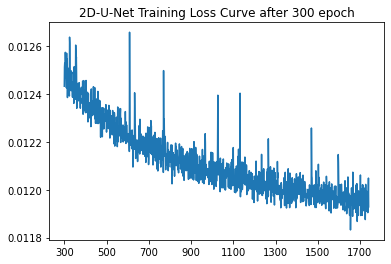

In [10]:
# Loss Curve for 2D Model
n_start = 300
y = np.arange(len(loss_arr_2d))
y = y[n_start:]
plt.figure()
plt.title(str("2D-U-Net Training Loss Curve after "+str(n_start)+" epoch"))
plt.plot(y, loss_arr_2d[n_start:,0])
plt.xticks(np.arange(min(y), max(y)+1, 200.0))
plt.xticks(np.arange(min(y), max(y)+1, 200.0))
plt.show()

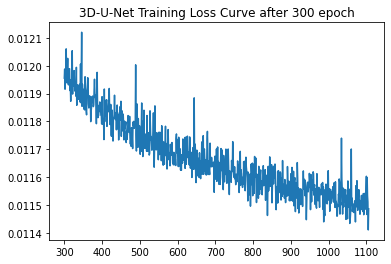

In [11]:
# Loss Curve for 3D Model
n_start = 300
y = np.arange(len(loss_arr_3d))
y = y[n_start:]
plt.figure()
plt.title(str("3D-U-Net Training Loss Curve after "+str(n_start)+" epoch"))
plt.plot(y, loss_arr_3d[n_start:,0])
plt.xticks(np.arange(min(y), max(y)+1, 100.0))
plt.xticks(np.arange(min(y), max(y)+1, 100.0))
plt.show()

In [12]:
dataset_len = test_loader.__len__()
print("Number of Patches in Test Dataset:",dataset_len)

Number of Patches in Test Dataset: 54


In [13]:
# Evaluate 2D Model

unet2d.eval()
fbp_arr_2d = np.empty((dataset_len,128,128,128))
gr_arr_2d = np.empty((dataset_len,128,128,128))
output_arr_2d = np.empty((dataset_len,128,128,128))

with torch.no_grad():
    for i,data in enumerate(tqdm(test_loader)):
        x, y = data
        
        x = x.reshape(batch_size*128, 1, 128, 128) # For 2D UNet
        y = y.reshape(batch_size*128, 1, 128, 128) # For 2D Unet
        
        x,y = x.to(device), y.to(device)

        output = unet2d(x)

        fbp_im_2d = x.cpu().numpy()
        gr_im_2d = y.cpu().numpy()
        output_im_2d = output.cpu().numpy()
        
        fbp_arr_2d[i,...] = np.squeeze(fbp_im_2d)
        gr_arr_2d[i,...] = np.squeeze(gr_im_2d)
        output_arr_2d[i,...] = np.squeeze(output_im_2d)


100%|██████████| 54/54 [00:14<00:00,  3.72it/s]


In [14]:
# Evaluate 3D Model

unet3d.eval()
fbp_arr_3d = np.empty((dataset_len,128,128,128))
gr_arr_3d = np.empty((dataset_len,128,128,128))
output_arr_3d = np.empty((dataset_len,128,128,128))

with torch.no_grad():
    for i,data in enumerate(tqdm(test_loader)):
        x, y = data
        x,y = x.to(device), y.to(device)

        output = unet3d(x)

        fbp_im_3d = x.cpu()
        gr_im_3d = y.cpu()
        output_im_3d = output.cpu()
        
        fbp_arr_3d[i,...] = np.squeeze(fbp_im_3d)
        gr_arr_3d[i,...] = np.squeeze(gr_im_3d)
        output_arr_3d[i,...] = np.squeeze(output_im_3d)


100%|██████████| 54/54 [00:16<00:00,  3.32it/s]


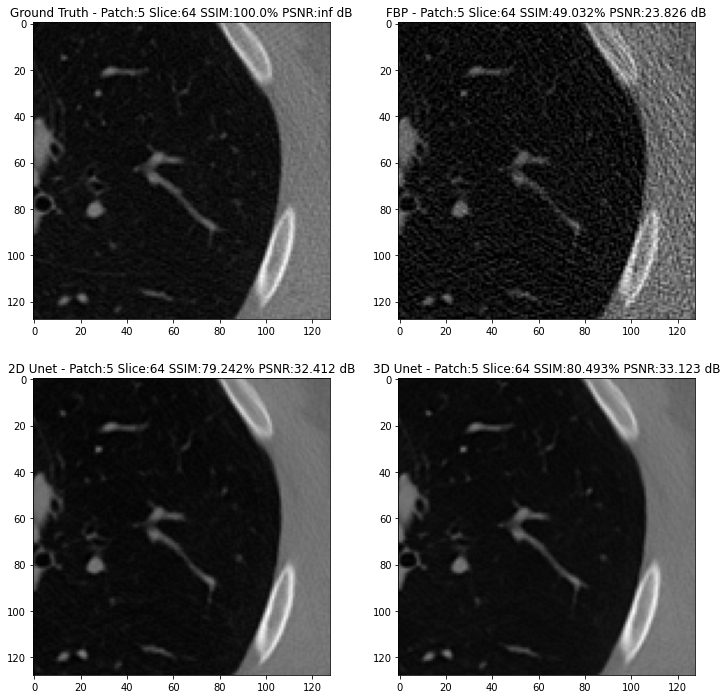

In [15]:
# Compare Ground Truth-FBP-2D and 3D U-Net

patch_no = 5 # Between 0 and 53
slice_no = 64 # Between 0 and 127
fig_size = (12,12) # Figure size

fig = plt.figure(figsize = fig_size)

# Ground Truth
fig.add_subplot(221)
plt.title('Ground Truth - Patch:'+ str(patch_no)+' Slice:'+ str(slice_no)+\
         ' SSIM:'+str(100*SSIM(gr_arr_2d[patch_no,slice_no,:,:],gr_arr_2d[patch_no,slice_no,:,:]).round(5)) + '%'\
         ' PSNR:'+str(PSNR(gr_arr_2d[patch_no,slice_no,:,:],gr_arr_2d[patch_no,slice_no,:,:]))+ ' dB')
plt.imshow(gr_arr_2d[patch_no,slice_no,:,:], cmap='gray')

# FBP
fig.add_subplot(222)
plt.title('FBP - Patch:'+ str(patch_no)+' Slice:'+ str(slice_no)+\
         ' SSIM:'+str(100*SSIM(fbp_arr_2d[patch_no,slice_no,:,:],gr_arr_2d[patch_no,slice_no,:,:]).round(5)) + '%'\
         ' PSNR:'+str(PSNR(fbp_arr_2d[patch_no,slice_no,:,:],gr_arr_2d[patch_no,slice_no,:,:]).round(3))+ ' dB')
plt.imshow(fbp_arr_2d[patch_no,slice_no,:,:], cmap='gray')

# 2D U-Net
fig.add_subplot(223)
plt.title('2D Unet - Patch:'+ str(patch_no)+' Slice:'+ str(slice_no)+\
         ' SSIM:'+str(100*SSIM(output_arr_2d[patch_no,slice_no,:,:],gr_arr_2d[patch_no,slice_no,:,:]).round(5)) + '%'\
         ' PSNR:'+str(PSNR(output_arr_2d[patch_no,slice_no,:,:],gr_arr_2d[patch_no,slice_no,:,:]).round(3))+ ' dB')
plt.imshow(output_arr_2d[patch_no,slice_no,:,:], cmap='gray')

# 3D U-Net
fig.add_subplot(224)
plt.title('3D Unet - Patch:'+ str(patch_no)+' Slice:'+ str(slice_no)+\
         ' SSIM:'+str(100*SSIM(output_arr_3d[patch_no,slice_no,:,:],gr_arr_2d[patch_no,slice_no,:,:]).round(5)) + '%'\
         ' PSNR:'+str(PSNR(output_arr_3d[patch_no,slice_no,:,:],gr_arr_2d[patch_no,slice_no,:,:]).round(3))+ ' dB')
plt.imshow(output_arr_3d[patch_no,slice_no,:,:], cmap='gray')
